In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram

In [24]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda RingMod"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 200
NUM_SETTINGS = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/tuxho3yv/checkpoints/epoch=289-step=60610.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
PEAK_NORMALISE = True

In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [27]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_audio=False,
        dummy_setting=False
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [28]:
dafx = dafx_from_name(DAFX_NAME)

In [29]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [30]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [31]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000])]

In [32]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=37152, out_features=128, bias=True)
  (log_var): Linear(in_features=37152, 

In [33]:
model.device

device(type='cuda', index=0)

In [34]:
latent_embeddings = dict()

In [35]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 11307.83it/s]


Loaded 88 files for train = 66.89 hours.


In [36]:
from tqdm import tqdm

for i in range(dafx.get_num_params()):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in tqdm(dataset):
            x = batch

            # Apply setting to audio
            x = dafx.apply(x, setting)
            x = x.unsqueeze(0).unsqueeze(0)

            X = audio_to_spectrogram(signal=x,
                         n_fft=model.hparams.n_fft,
                         hop_length=model.hparams.hop_length,
                         window_size=model.hparams.window_size).to(DEVICE)

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


Interpolating setting: freq_hz
Applying setting: tensor([0.0000, 0.5000, 0.5000])


100%|██████████| 200/200 [00:06<00:00, 30.77it/s] 


Applying setting: tensor([0.1111, 0.5000, 0.5000])


100%|██████████| 200/200 [00:06<00:00, 32.84it/s]


Applying setting: tensor([0.2222, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 44.16it/s] 


Applying setting: tensor([0.3333, 0.5000, 0.5000])


100%|██████████| 200/200 [00:03<00:00, 50.20it/s] 


Applying setting: tensor([0.4444, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 43.11it/s] 


Applying setting: tensor([0.5556, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 42.65it/s]


Applying setting: tensor([0.6667, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 47.17it/s]


Applying setting: tensor([0.7778, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 42.80it/s]


Applying setting: tensor([0.8889, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 47.54it/s] 


Applying setting: tensor([1.0000, 0.5000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 44.91it/s] 


Interpolating setting: fine_hz
Applying setting: tensor([0.5000, 0.0000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 45.06it/s] 


Applying setting: tensor([0.5000, 0.1111, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 47.00it/s] 


Applying setting: tensor([0.5000, 0.2222, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 40.36it/s] 


Applying setting: tensor([0.5000, 0.3333, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 44.65it/s] 


Applying setting: tensor([0.5000, 0.4444, 0.5000])


100%|██████████| 200/200 [00:03<00:00, 50.43it/s]


Applying setting: tensor([0.5000, 0.5556, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 45.81it/s]


Applying setting: tensor([0.5000, 0.6667, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 47.11it/s]


Applying setting: tensor([0.5000, 0.7778, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 43.58it/s] 


Applying setting: tensor([0.5000, 0.8889, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 46.40it/s] 


Applying setting: tensor([0.5000, 1.0000, 0.5000])


100%|██████████| 200/200 [00:04<00:00, 47.71it/s]


Interpolating setting: feedback
Applying setting: tensor([0.5000, 0.5000, 0.0000])


100%|██████████| 200/200 [00:04<00:00, 45.62it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.1111])


100%|██████████| 200/200 [00:04<00:00, 49.60it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.2222])


100%|██████████| 200/200 [00:04<00:00, 47.96it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.3333])


100%|██████████| 200/200 [00:04<00:00, 48.08it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.4444])


100%|██████████| 200/200 [00:04<00:00, 43.68it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.5556])


100%|██████████| 200/200 [00:04<00:00, 45.10it/s] 


Applying setting: tensor([0.5000, 0.5000, 0.6667])


100%|██████████| 200/200 [00:04<00:00, 44.81it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7778])


100%|██████████| 200/200 [00:05<00:00, 35.89it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8889])


100%|██████████| 200/200 [00:04<00:00, 48.97it/s] 


Applying setting: tensor([0.5000, 0.5000, 1.0000])


100%|██████████| 200/200 [00:05<00:00, 34.89it/s]


In [37]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [38]:
data.shape

(6000, 128)

In [39]:
import umap

In [48]:
reducer = umap.UMAP(n_neighbors=100).fit(data)

In [49]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

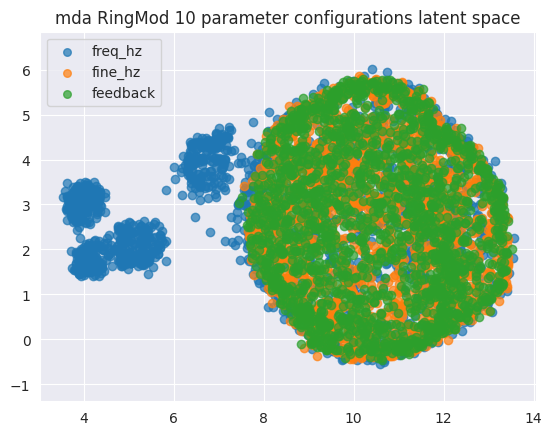

In [50]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_full.png"
plt.savefig(figname)

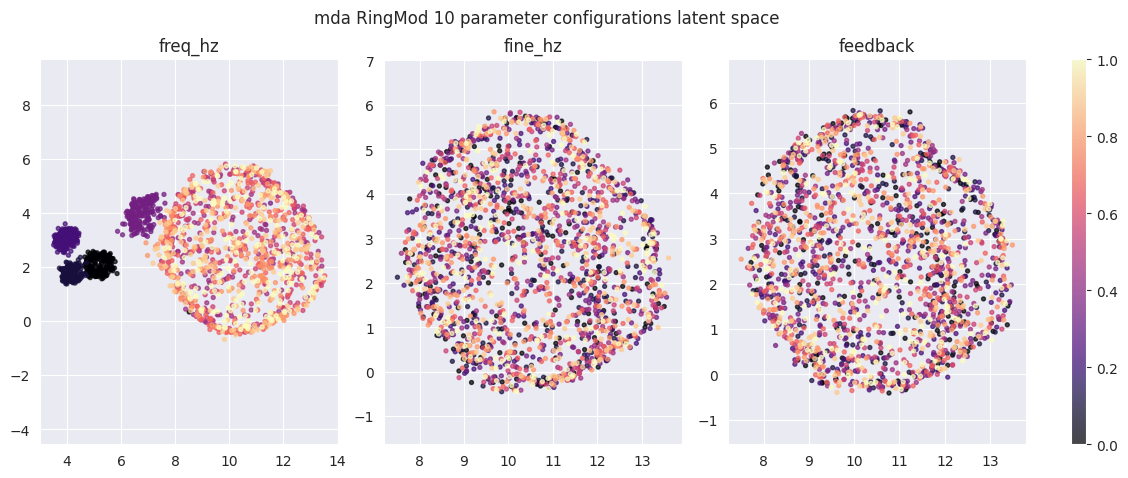

In [51]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])

for i in range(dafx.get_num_params()):
    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    ax = fig.add_subplot(gs[0, i])
    sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, c=colours, vmin=0, vmax=1, s=8, cmap='magma')

    ax.set_title(param_name)
    ax.set_aspect('equal', 'datalim')

plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(sc, cax=cax)

fig.subplots_adjust(right=0.9)

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_seperate.png"
plt.savefig(figname)